In [1]:
import tensorflow as tf 
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import rcParams

tf.keras.config.set_floatx('float64')



#Parameters of the model#
##########################################################################################
# Define the number of neuron per layer
NN = 5
#Define the number of layers 
NL = 3
#Define number of collocation points
N_points = 100

N_test = 30 # per time step

# Define the number of epochs
N_epoch = 1000

## Time discretization
delta_t = 0.001
t_steps = 100
#########################################################################################







# # Define the manufactured solution
def u_sol(x, t):
    return tf.exp(-t) * tf.sin(x)

# # Compute the time derivative of u (u_t)
# def u_t(x, t):
#     return -tf.exp(-t) * tf.sin(x)

# # Compute the Laplacian of u (u_xx) in one dimension
# def u_xx(x, t):
#     return -tf.exp(-t) * tf.sin(x)

# Compute the source term f(x, t) = u_t - u_xx
def f_source(x,t):
    return -tf.exp(t)*tf.sin(x)*(np.pi**2-1)

def U_init(x):
    return tf.sin(x)

# PARA IMPONER CONDICIONES DE FRONTERA
class cutoff(tf.keras.layers.Layer):

    def __init__(self,**kwargs):
        super(cutoff,self).__init__()
    
    def call(self,inputs):
    
        x,u =inputs
        cut = x*(x-np.pi)
            
        return tf.einsum("ji,j->ji",cut,u) 



#Input dummy
X = tf.keras.layers.Input(shape = (1,))

#Define the first layer with dummy input
L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(X)

#Feed the first layer to a generic layer for the number of layers, without the first and last layers
for l in range(NL - 2):
    L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(L1)

#Last layer after being fed with the second to last layer (1 output)
L_last = tf.keras.layers.Dense(units=t_steps, activation = 'tanh',dtype='float64')(L1)

L_out = []
for i in range(t_steps):
    L0 = cutoff()([X,L_last[:,i]])
    L_out.append(L0)
    

#Assembly the model
U_model = tf.keras.Model(inputs = X, outputs = L_out, name = 'U_model')

#model summary
#U_model.summary()


In [2]:
#Define a class for the loss, we are going to call this class in every iteration, 
# evaluating this on the randomized sample, the target function and the output 
# of the network
###############################################################################
#Parameters for the class "loss": U_model --> Neural Network Architecture     #
#           N_points --> Number of Sampled points across the problem's domain #
#           f_source --> Source function on the PDE -Δu = f                   #
###############################################################################
class loss(tf.keras.layers.Layer):

    def __init__(self, U_model, N_points,f_source,N_test,t_steps,U_init,delta_t, **kwargs):
        super(loss,self).__init__()
        self.U_model = U_model
        self.N_points = N_points
        self.f_source = f_source
        self.N_test = N_test
        self.t_steps = t_steps
        self.U_init = U_init
        self.dt = delta_t

    #Compute the derivative of the neural network U_nn
    def  call(self,input):
        
        #Get a sample of points in the domain for the integration. 
        N_pointsreal = self.N_points #random.randint(self.N_points-1, self.N_points)
        
        S = tf.experimental.numpy.linspace(0.,np.pi,num=N_pointsreal, dtype='float64')
       
        with tf.GradientTape(persistent=True) as t1:       
            t1.watch(S)
            # Ojo: la salida de esto tf.transpose(U_model(xlist)) es tf.Tensor: shape=(tiempos,espacio)
            ueval = tf.squeeze(self.U_model(S)) # (tiempos,espacio)

            loss_out = 0
            for t in range(self.t_steps):
              
                #Compute a vector of the source function evaluated in the sample points & 
                F = self.f_source(S,tf.constant(t*self.dt,dtype=tf.float64))

                # Arma las funciones de base que usamos en la integral de la fuente
                G = tf.experimental.numpy.asarray([(1/i)*(np.sqrt(2)/np.pi)*tf.math.sin(i*S) 
                                                   for i in range(1,self.N_test+1)],dtype='float64')
        
                if t == 0:
                    U0 = self.U_init(S)
                    Integral_source = tf.einsum('i,ki->k',self.dt*F-U0,G)
                else:
                    Integral_source = tf.einsum('i,ki->k',self.dt*F-ueval[t-1],G)

                # Arma el gradiente de las funciones de base que usamos en la integral maluca
                H = tf.experimental.numpy.asarray([(np.sqrt(2)/np.pi)*tf.cos(i*S) 
                                                   for i in range(1,self.N_test+1)],dtype='float64')
            
                u_x_tn = t1.gradient(ueval[t],S)
                
                Integral_Unn = tf.einsum('i,ki->k',u_x_tn,H)

                Integral_nueva = tf.einsum('i,ki->k',ueval[t],G)

                loss_out += tf.reduce_sum((Integral_nueva + self.dt*Integral_Unn + Integral_source)**2)
        
        del t1

        return loss_out



#Tell tensorlofw to recognize this class as a loss
def loss_model(U_model,N_points, f_source,N_test,t_steps,U_init,dt):
    Xl = tf.keras.layers.Input(shape = (1,),dtype='float64')
    loss_layer = loss(U_model, N_points, f_source,N_test,t_steps,U_init,dt)(Xl)
    loss_f = tf.keras.Model(inputs = Xl, outputs = loss_layer)
    return loss_f

def loss_value(x,y):
    return y

#Assemble the model
model_all = loss_model(U_model,N_points,f_source,N_test,t_steps,U_init,delta_t)
optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-3)
model_all.compile(optimizer = optimizer, loss = loss_value)

#Train the model
history = model_all.fit(np.array([1.]),np.array([1.]),epochs = N_epoch)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 145s 145s/step - loss: 354180992.0000
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 354160960.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 354141120.0000
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 354121504.0000
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 354102080.0000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 354082848.0000
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 354063776.0000
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 354044832.0000
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 354026016.0000
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 354007392.0000
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 353988864.0000
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 353970528.0000
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 353952288.0000
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━

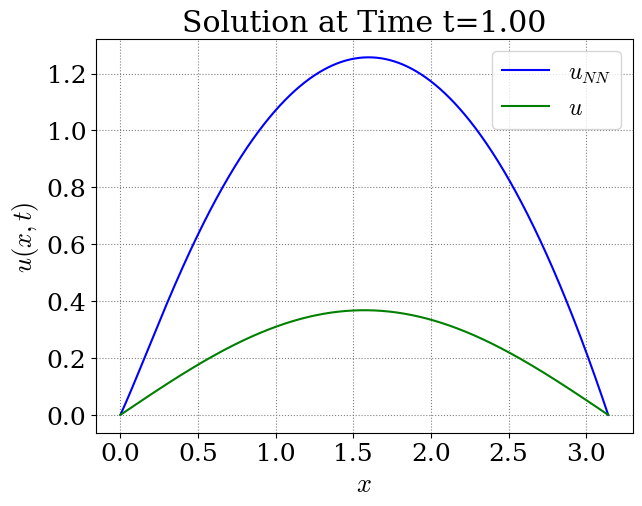

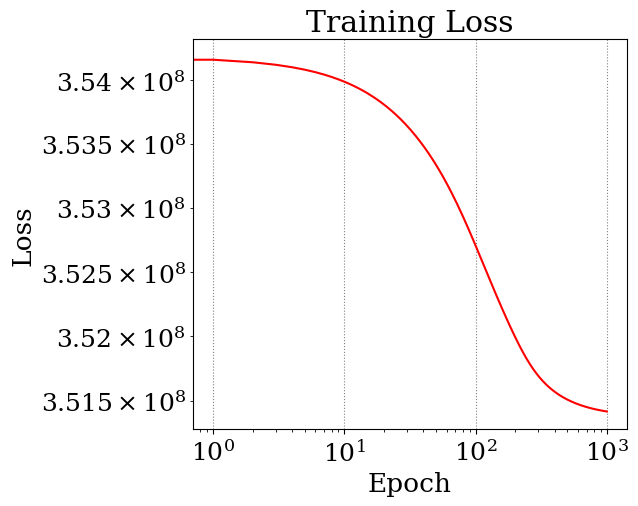

In [3]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 17
rcParams['mathtext.fontset'] = 'cm' 
rcParams['axes.labelsize'] = 19

# Define parameters
#delta_t = 0.01  # Ensure delta_t is correctly defined
t = 10       # Current time step
current_time = t * delta_t  # Compute the actual time for the exact solution

# Generate a list of x values for visualization
xlist = tf.experimental.numpy.linspace(0., np.pi, num=1000, dtype='float32')

# Evaluate the neural network output
uu = tf.squeeze(U_model(xlist))  # Output should be structured as (time, space)

# Ensure uu has the correct shape
assert uu.shape[0] > t - 1, f"Time step {t} exceeds the output range of the model."

# Graph the solutions
fig, ax = plt.subplots()

# Plot the neural network approximation at time t
plt.plot(xlist, uu[t-1], color='b', label='$u_{NN}$')

# Plot the exact solution at the same time step
plt.plot(xlist, tf.exp(-current_time) * tf.sin(xlist), color='g', label='$u$')

plt.ylim(0, 1)

# Add legend and grid
plt.legend()
ax.grid(which='both', axis='both', linestyle=':', color='gray')

# Format and display the plot
plt.tight_layout()
plt.title(f'Solution at Time t={current_time:.2f}')
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.show()

# Plot the training loss
Loss_rel = history.history['loss']

fig, ax = plt.subplots()
plt.plot(Loss_rel, color='r')

# Set log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add grid and title
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.tight_layout()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


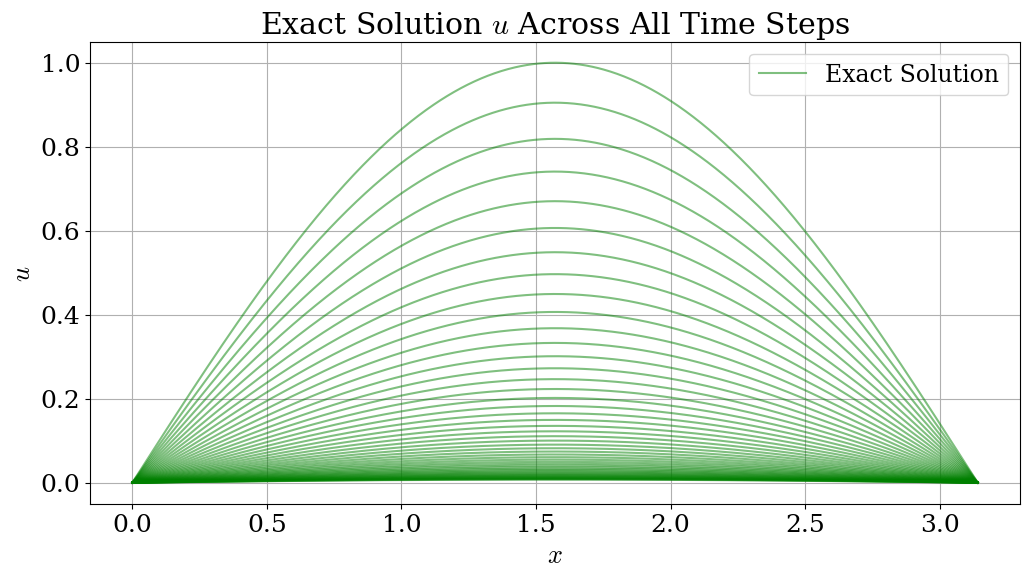

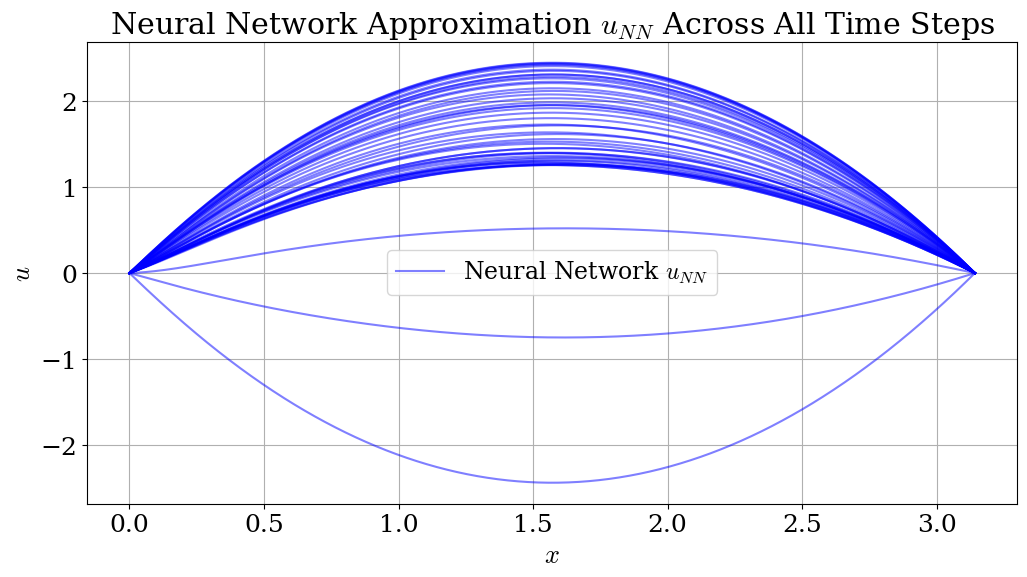

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Parameters
#delta_t = 0.01  # Time step size
#t_steps = 50    # Total number of time steps
xlist = tf.experimental.numpy.linspace(0., np.pi, num=1000, dtype='float32')


# Evaluate the neural network output
uu = tf.squeeze(U_model(xlist))  # Output should be structured as (time, space)

# Ensure uu has the correct shape
assert uu.shape[0] > t - 1, f"Time step {t} exceeds the output range of the model."

# Plot the exact solution over all time steps
fig, ax1 = plt.subplots(figsize=(12, 6))
for t in range(t_steps):
    current_time = t * delta_t  # Actual time for the exact solution
    u_exact = tf.exp(-current_time) * tf.sin(xlist)  # Exact solution
    ax1.plot(xlist, u_exact, color='g', alpha=0.5, label='Exact Solution' if t == 0 else "")


ax1.set_title("Exact Solution $u$ Across All Time Steps")
ax1.set_xlabel("$x$")
ax1.set_ylabel("$u$")
ax1.legend()
ax1.grid()

# Plot the neural network output over all time steps
fig, ax2 = plt.subplots(figsize=(12, 6))
for t in range(t_steps):
    u_nn = uu[t]  # Neural network solution at time t
    ax2.plot(xlist, u_nn, color='b', alpha=0.5, label='Neural Network $u_{NN}$' if t == 0 else "")

ax2.set_title("Neural Network Approximation $u_{NN}$ Across All Time Steps")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$u$")
ax2.legend()
ax2.grid()

plt.show()



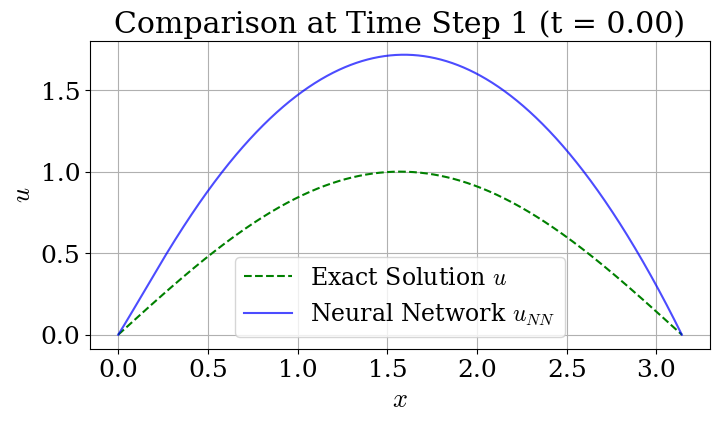

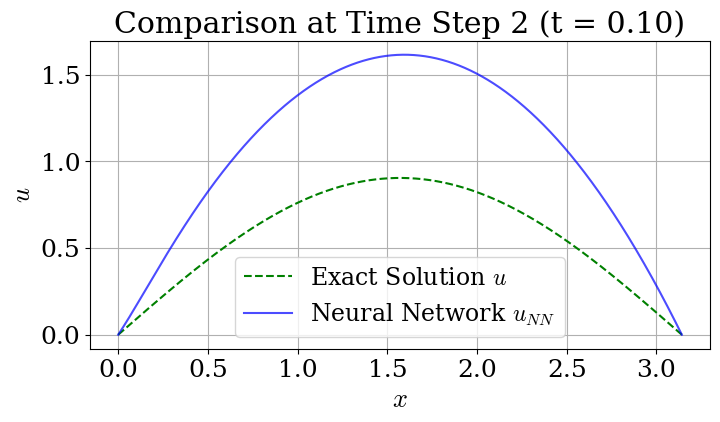

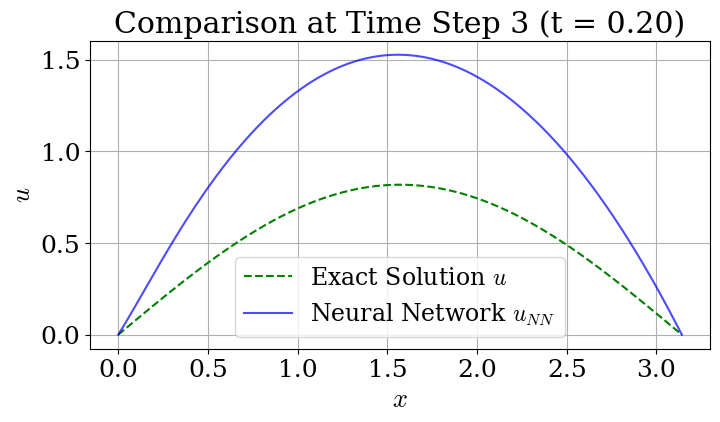

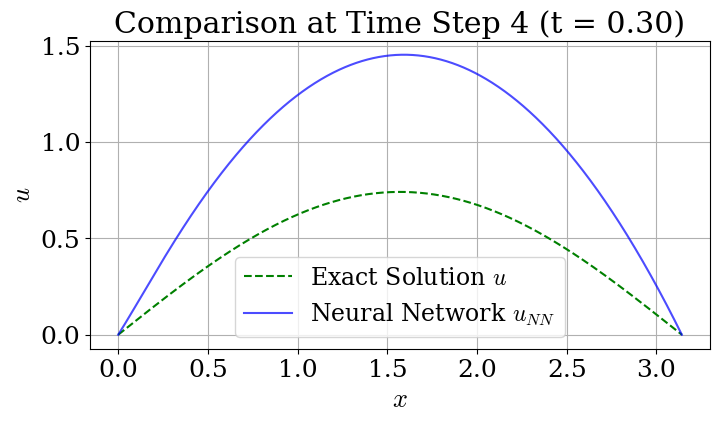

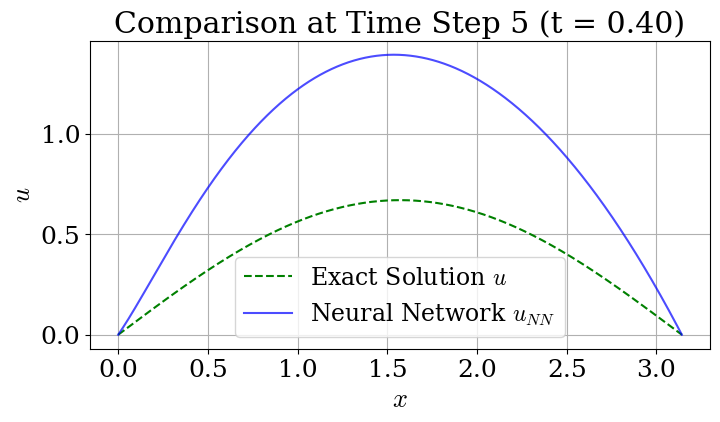

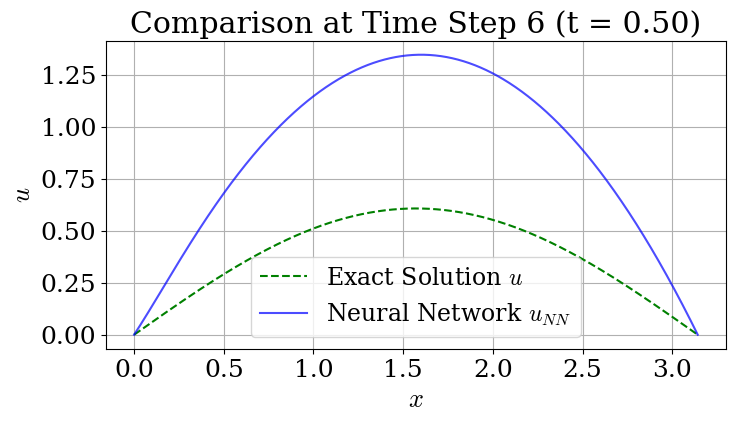

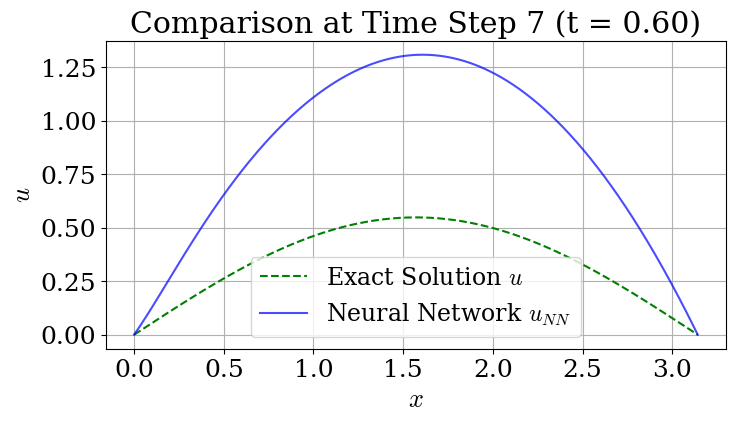

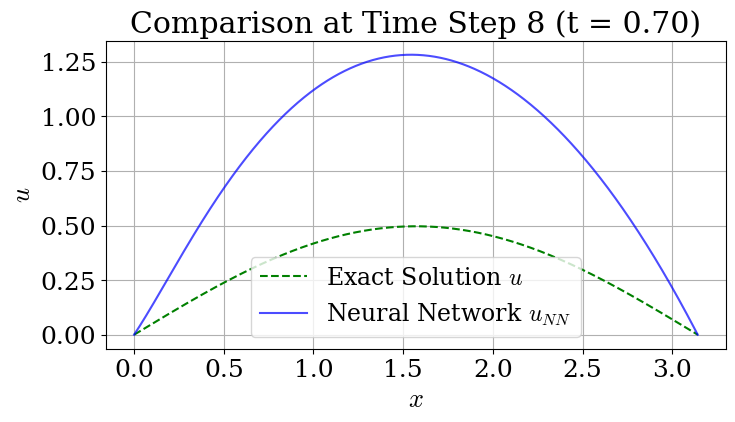

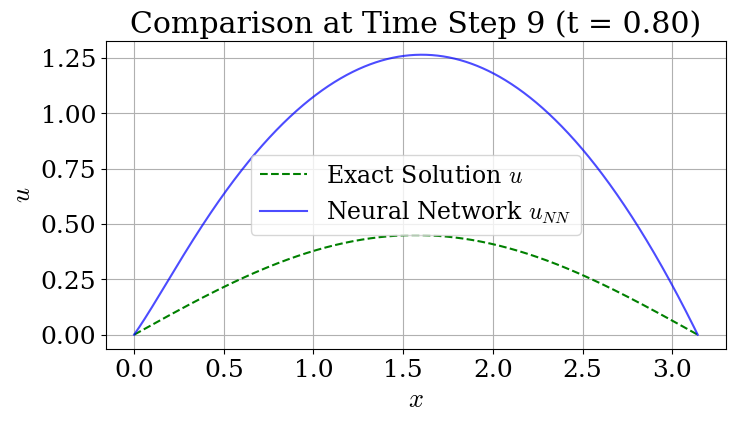

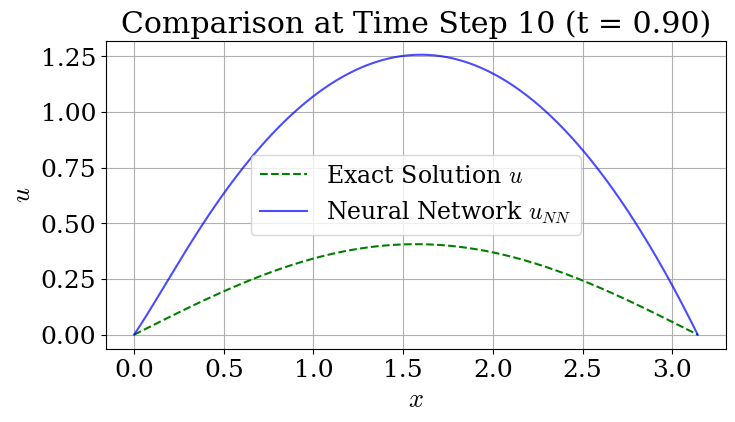

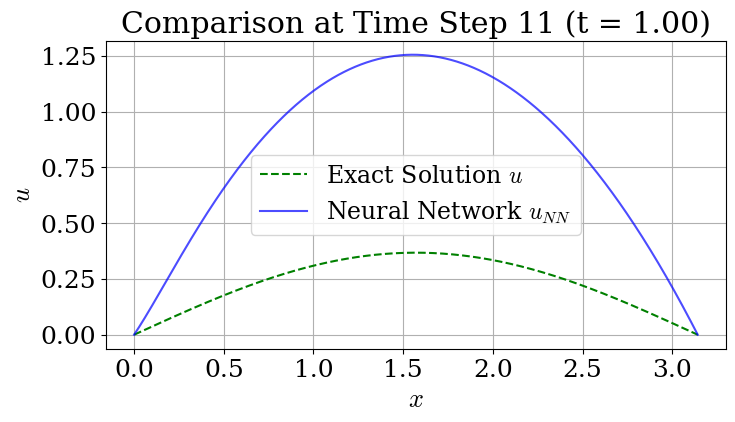

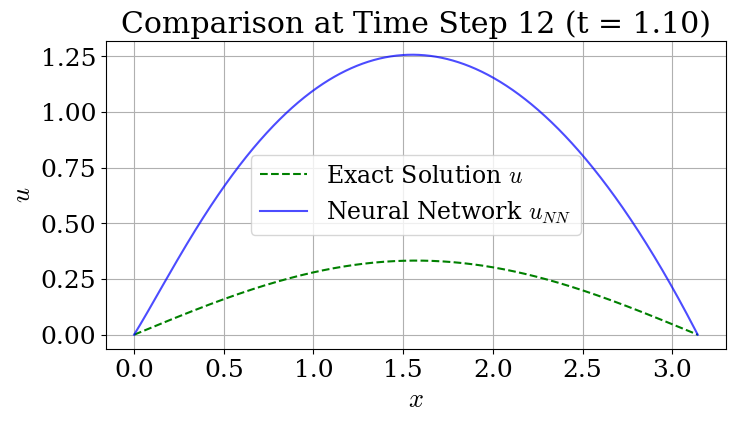

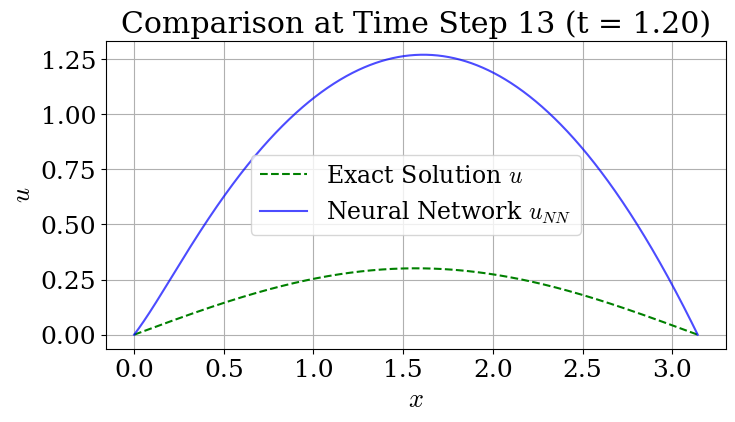

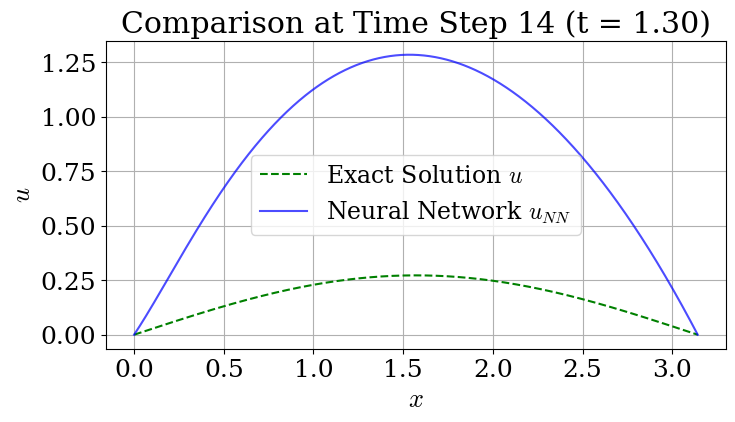

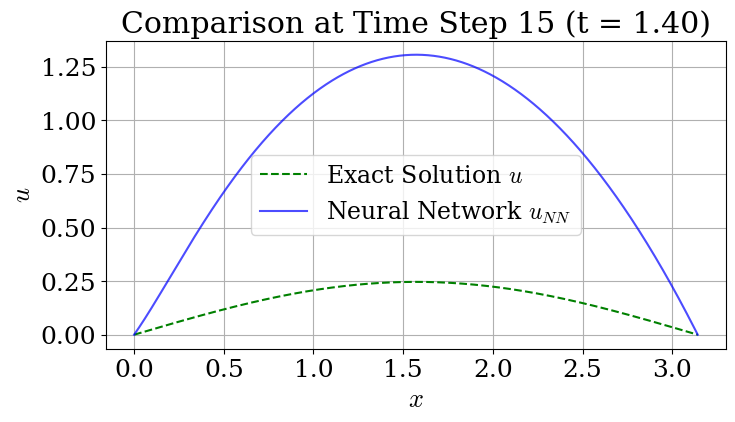

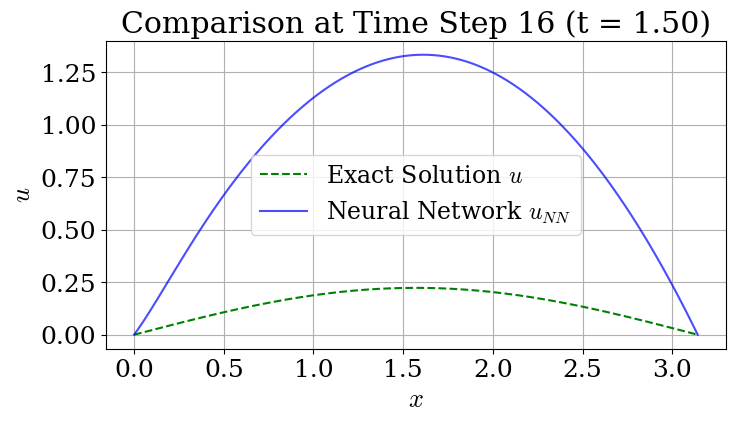

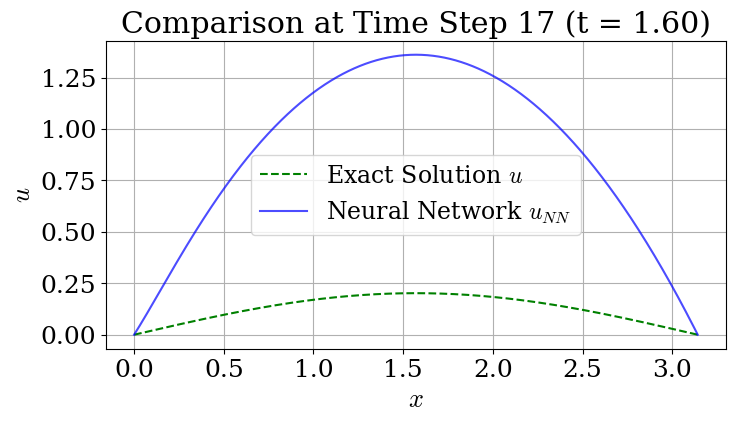

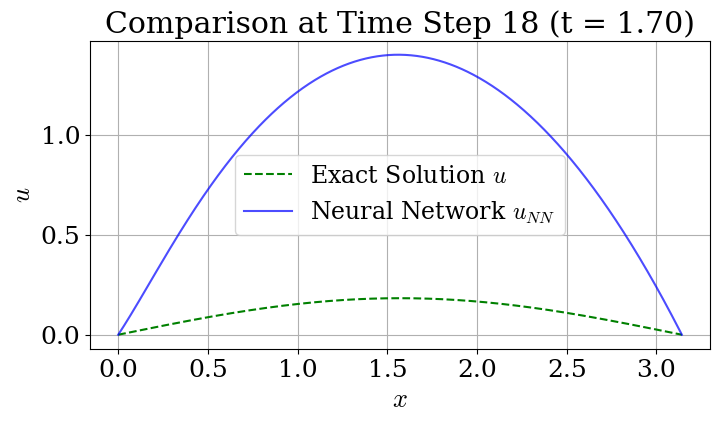

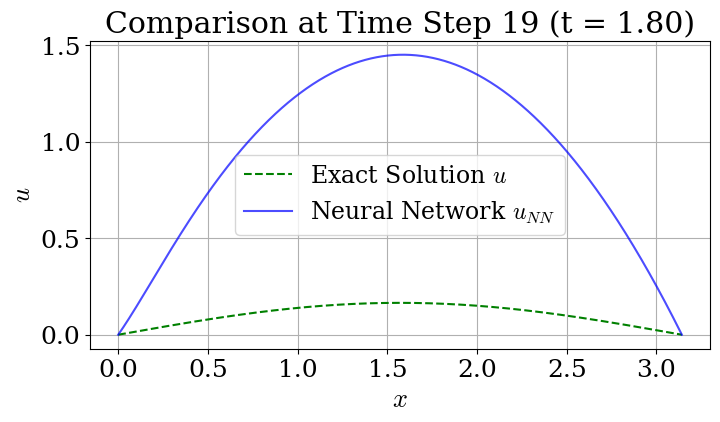

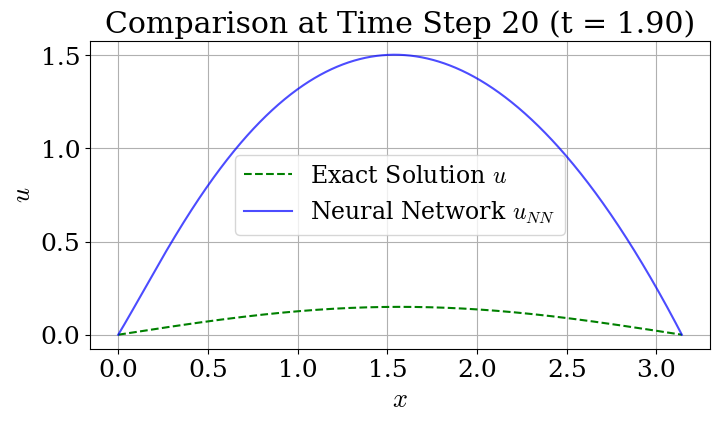

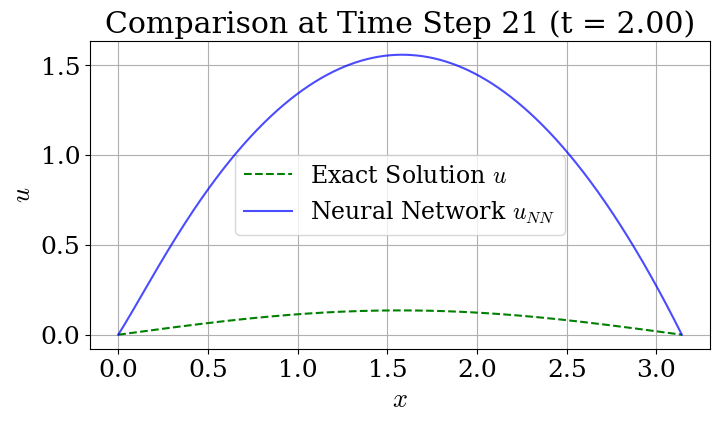

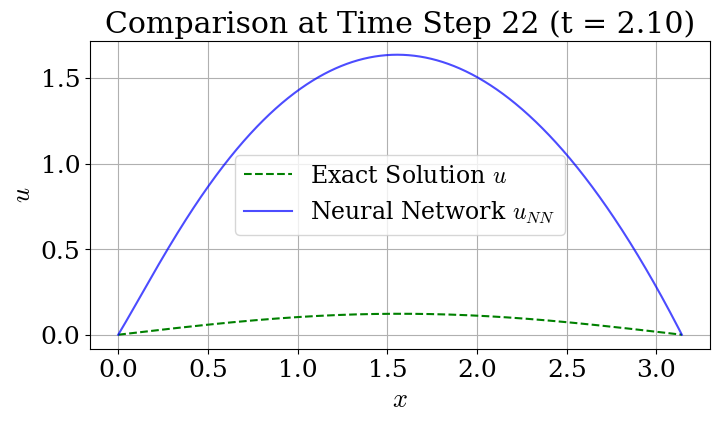

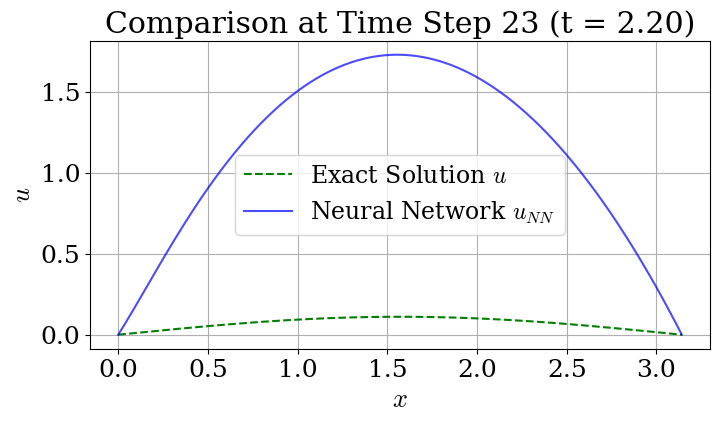

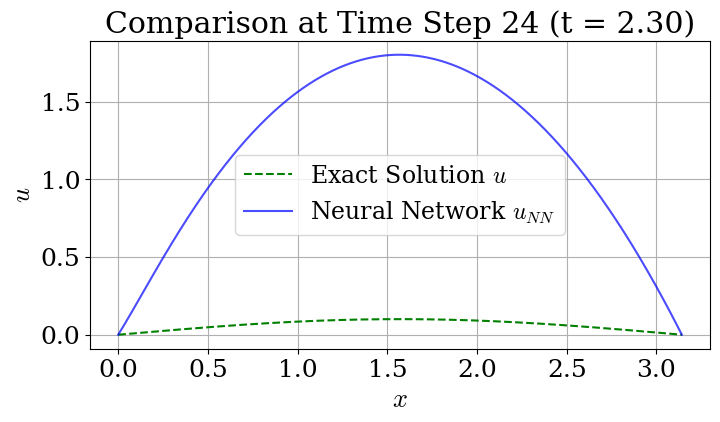

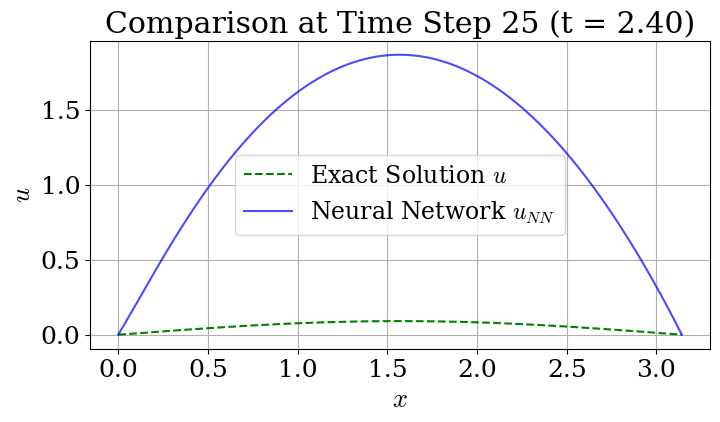

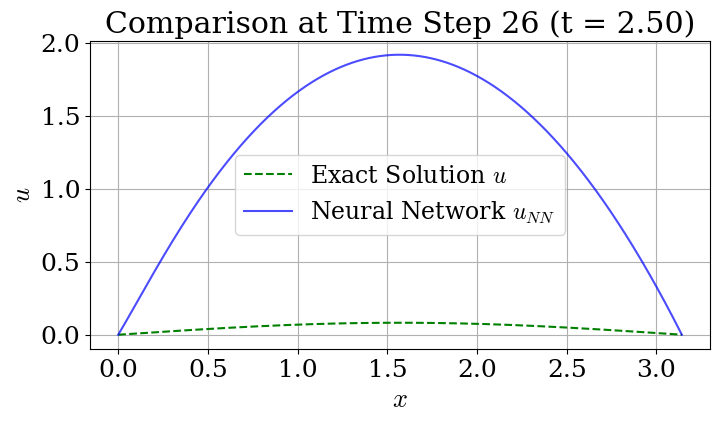

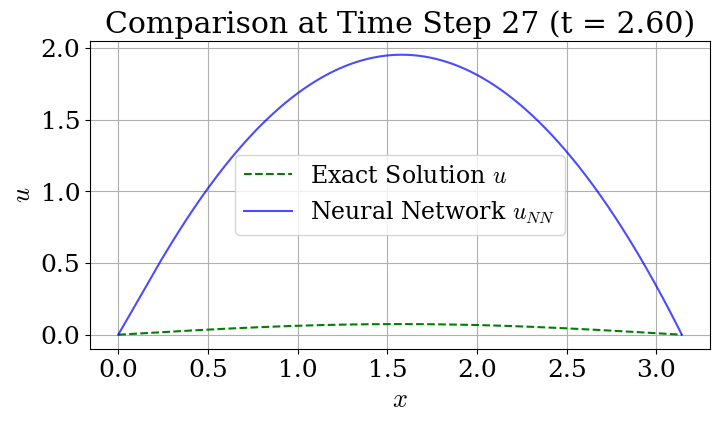

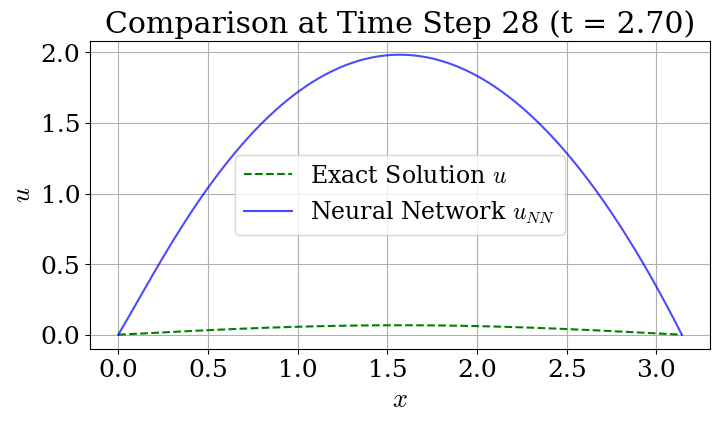

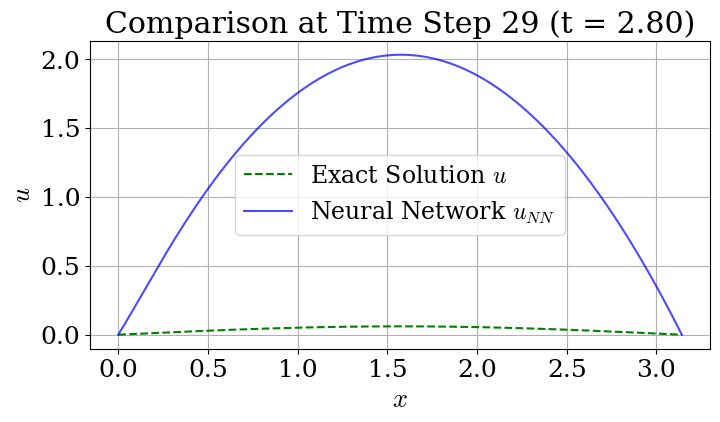

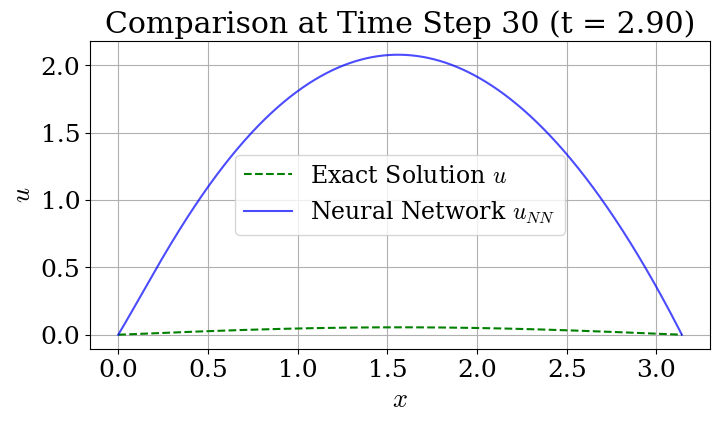

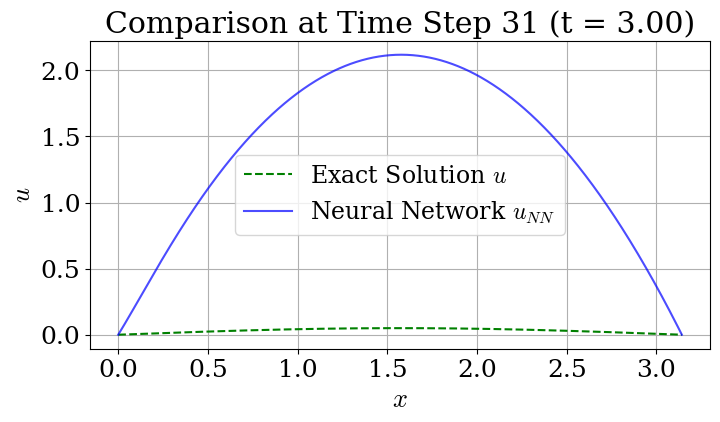

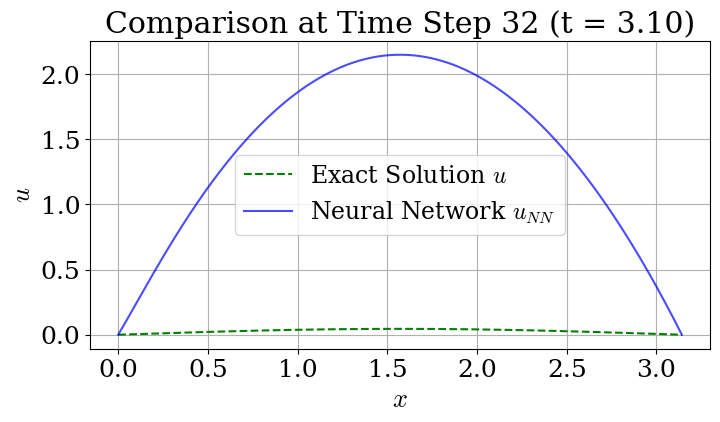

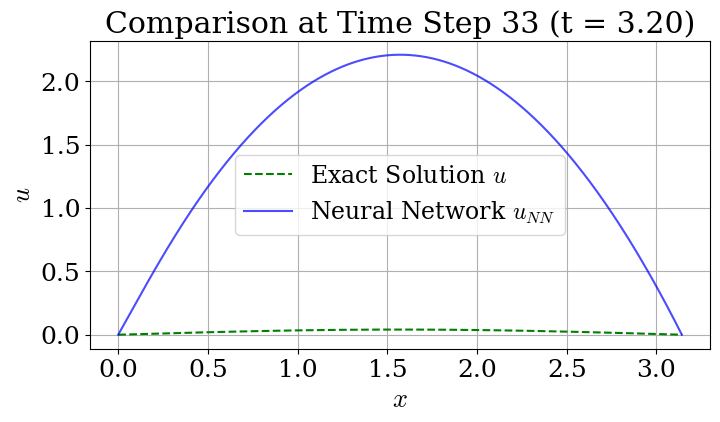

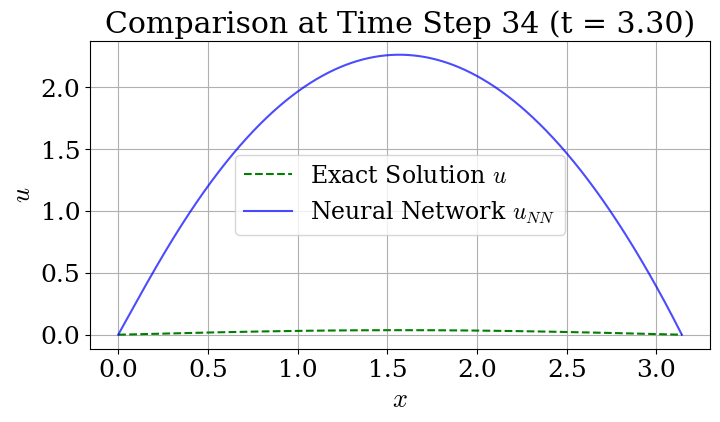

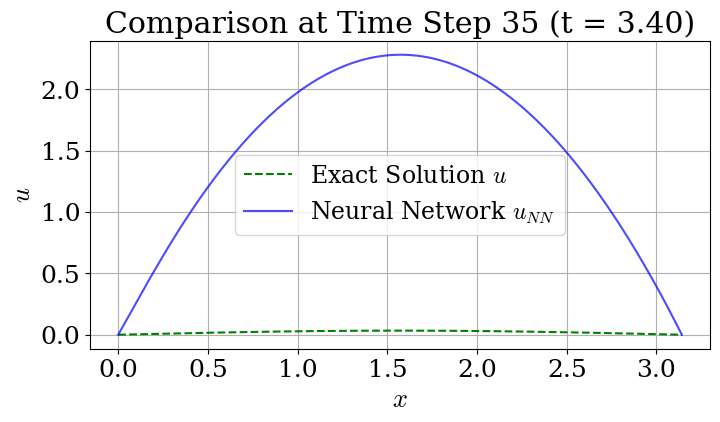

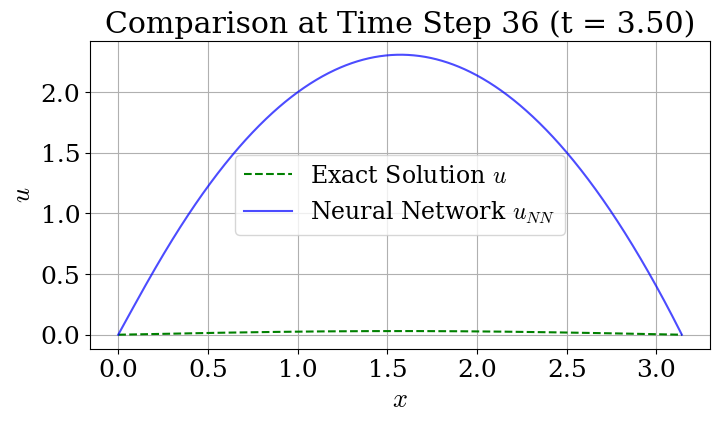

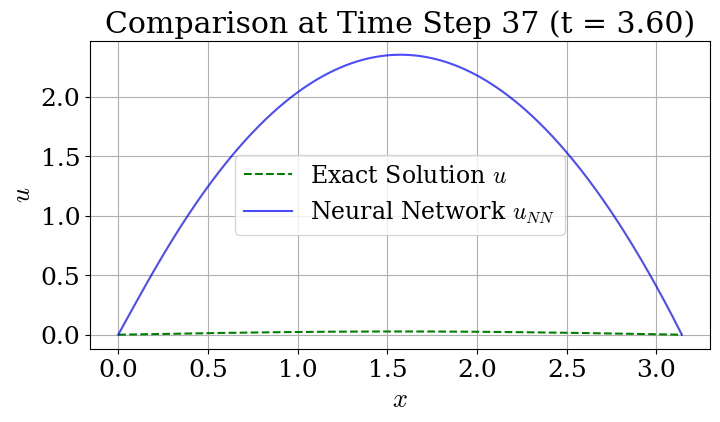

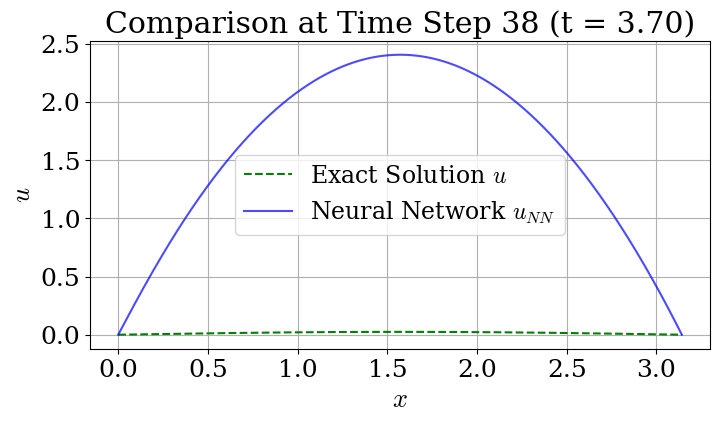

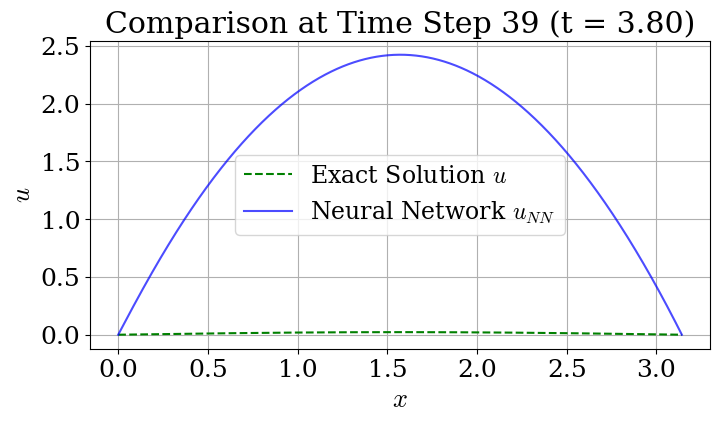

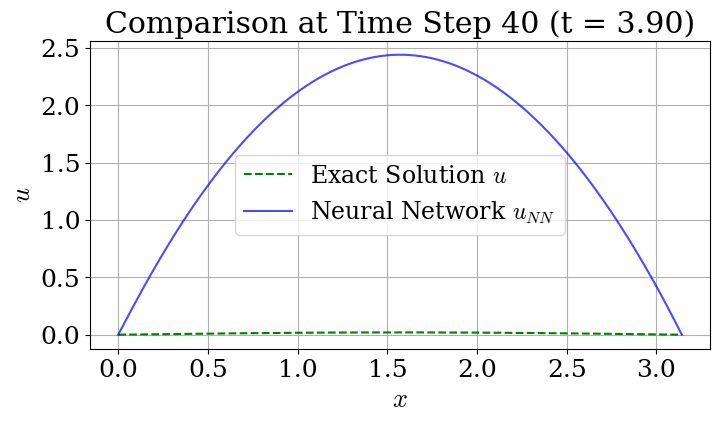

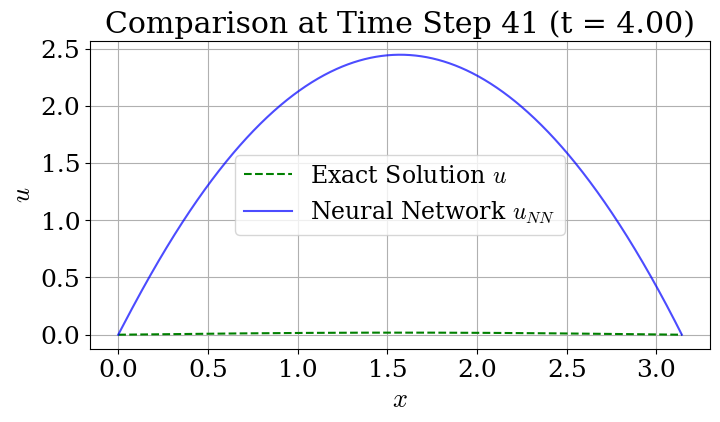

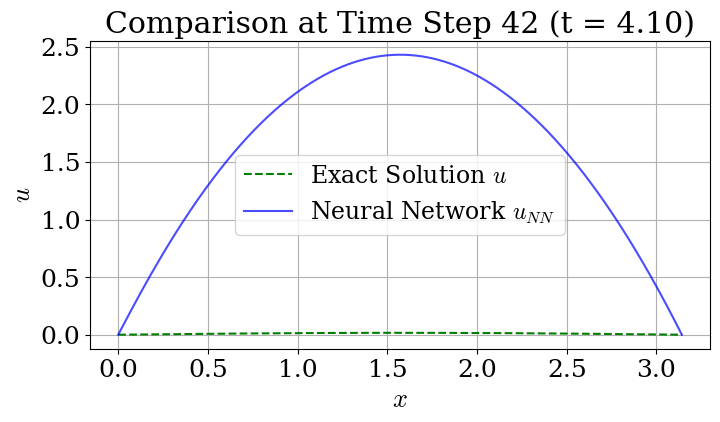

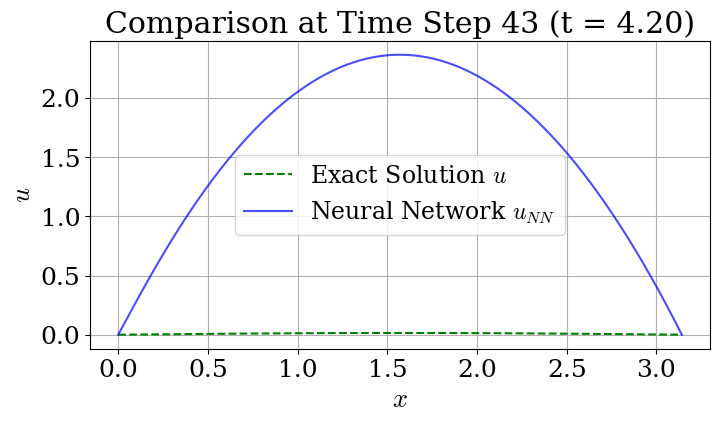

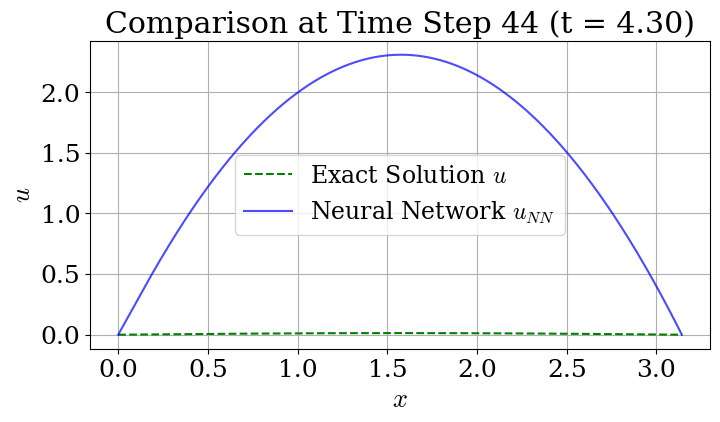

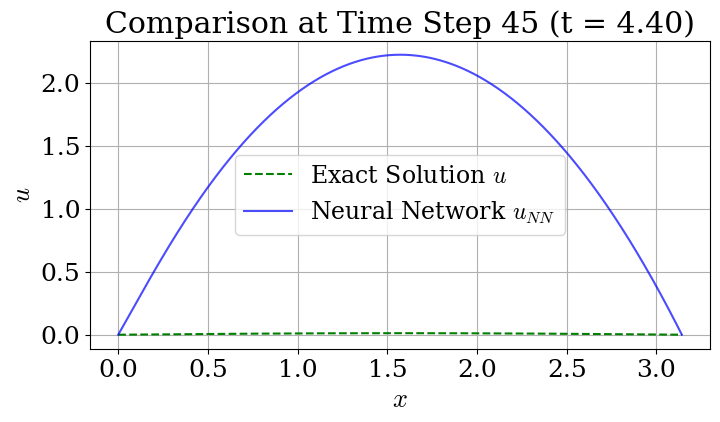

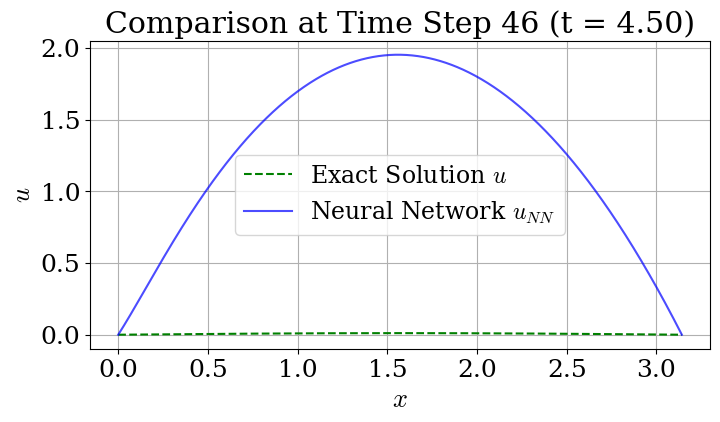

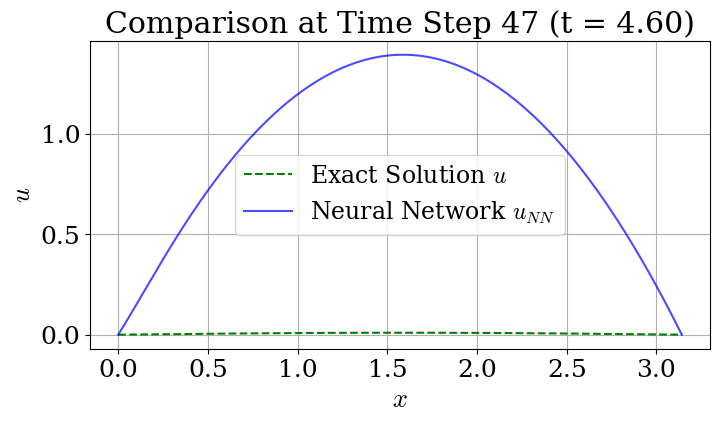

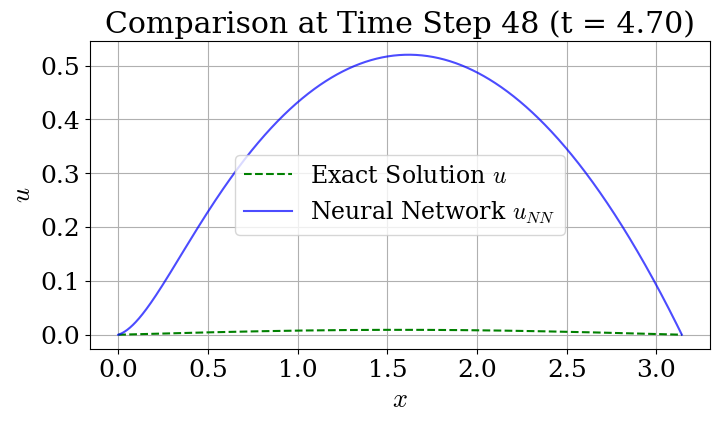

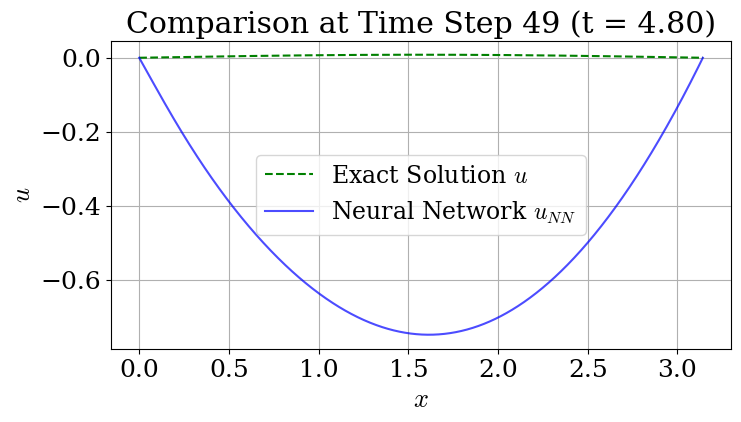

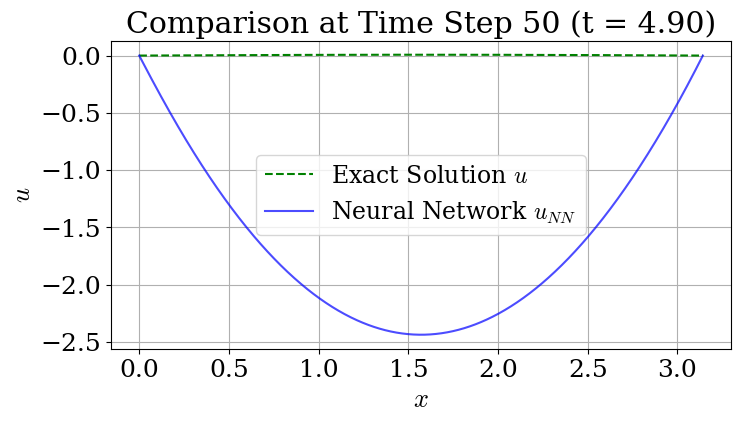

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Parameters
#delta_t = 0.01  # Time step size
#t_steps = 50    # Total number of time steps
xlist = tf.experimental.numpy.linspace(0., np.pi, num=1000, dtype='float32')

uu = tf.squeeze(U_model(xlist))  # Output should be structured as (time, space)

# Ensure uu has the correct shape
assert uu.shape[0] > t - 1, f"Time step {t} exceeds the output range of the model."

# Generate comparison graphs for each time step
for t in range(t_steps):
    current_time = t * delta_t  # Actual time for the exact solution
    u_exact = tf.exp(-current_time) * tf.sin(xlist)  # Exact solution
    u_nn = uu[t]  # Neural network approximation at time t

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(xlist, u_exact, color='g', label='Exact Solution $u$', linestyle='--')
    ax.plot(xlist, u_nn, color='b', label='Neural Network $u_{NN}$', alpha=0.7)
    plt.ylim(0, 1)
    ax.set_title(f"Comparison at Time Step {t + 1} (t = {current_time:.2f})")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u$")
    ax.legend()
    ax.grid()
    plt.show()
